# Clustering Simulation Evaluation

In [1]:
# SAVE 데이터 로드
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

### 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan
SAVE = SAVE.loc[pd.to_datetime('2017-01-01 00:00'):,:]

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

### 라벨 로드
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
# Interviedate가 빠른 순으로 정렬
SAVE_label.sort_values('InterviewDate', inplace = True)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

# 라벨 순서를 데이터 순서와 맞춤
valid_col = []
for col in SAVE.columns:
    if col in SAVE_label.columns:
        valid_col.append(col)

SAVE_label = SAVE_label[valid_col].T
SAVE = SAVE[valid_col]
print('Done load SAVE')
SAVE[SAVE == 0] = np.nan

# CER 데이터 로드
# %% load dataset
# start_date = pd.to_datetime('2010-09-01 00:00:00')
# end_date = pd.to_datetime('2009-12-01 23:00:00')

power_df = pd.read_csv('data/CER/power_comb_SME_included.csv')

# 0 to NaN
power_df[power_df==0] = np.nan
power_df['time'] = pd.to_datetime(power_df['time'])
power_df.set_index('time', inplace=True)

# load label
CER_label = pd.read_csv('data/CER/survey_processed_0427.csv')
CER_label['ID'] = CER_label['ID'].astype(str)
CER_label.set_index('ID', inplace=True)

CER = power_df.loc[:,CER_label.index]
del power_df
print('Done load CER')

## 기간을 6개월 한정
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:45:00')

SAVE = SAVE.loc[start_date:end_date,:]

start_date = pd.to_datetime('2010-01-01 00:00:00')
end_date = pd.to_datetime('2010-06-30 23:30:00')

CER = CER.loc[start_date:end_date,:]

# Downsampling SAVE
n = SAVE.shape[0]
list_ = []
time_ = []
for i in range(0, n, 2):
    data = SAVE.iloc[i:i+2,:]
    invalid_data_idx = np.any(pd.isnull(data), axis=0)
    data = data.sum(axis=0)
    data.iloc[invalid_data_idx] = np.nan
    list_.append(data)
    time_.append(SAVE.index[i])
list_ = pd.concat(list_, axis=1).T
list_.index = time_
SAVE = list_
del list_

print(SAVE.shape)
print(CER.shape)


Done load SAVE
Done load CER
(8688, 3934)
(8688, 4232)


In [80]:
# load ETRI
ETRI = pd.read_csv('data/ETRI/label_0427.csv', index_col=0)
ETRI.index = pd.to_datetime(ETRI.index)
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:00:00')
ETRI = ETRI.loc[start_date:end_date,:]
ETRI_label = pd.read_csv('data/ETRI/survey_0427.csv', index_col = 0)
ETRI[ETRI == 0] = np.nan

nan_ratio = pd.isnull(ETRI).sum(axis=0) / ETRI.shape[0]
invalid_idx = (nan_ratio == 1)
ETRI = ETRI.loc[:,~invalid_idx]
ETRI_label = ETRI_label.T.loc[~invalid_idx,:]


### invalid house processing

In [2]:
nan_ratio = pd.isnull(SAVE).sum(axis=0) / SAVE.shape[0]
invalid_idx = (nan_ratio == 1)
SAVE = SAVE.loc[:,~invalid_idx]
SAVE_label = SAVE_label.loc[~invalid_idx,:]

nan_ratio = pd.isnull(CER).sum(axis=0) / CER.shape[0]
invalid_idx = (nan_ratio == 1)
CER = CER.loc[:,~invalid_idx]
CER_label = CER_label.loc[~invalid_idx,:]

print(CER.shape)
print(CER_label.shape)


(8688, 3248)
(3248, 15)


### daily형태로 변환

| 데이터|Shape|
|: ------------- :|:-------------:|
| CER_rs      | (house * day , 0-48)|
| CER_p1      | (house * day , 0-18 & 36-48)|
| CER_p2      | (house * day , 18-36)|

In [253]:
def transform(df, sampling_interv = 24 * 2 * 7):
    '''
    [input]
    df: dataframe (timeseries, home)
    
    [output]
    data_2d: 2d array
    home_arr: home index array
    '''

    # dataframe => 3d numpy array
    n_d, n_h = df.shape
    n_w = n_d // sampling_interv
    n_d = n_w * sampling_interv
    df_rs = df.iloc[:n_d,:].values.T.reshape(n_h, -1, sampling_interv)

    # 3d numpy array => 2d numpy array
    n, m, l = df_rs.shape
    data_2d = df_rs.reshape(n*m, l)
    home_arr = np.repeat(np.arange(0, n), m)
    invalid_idx = np.any(pd.isnull(data_2d), axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    # constant load filtering
    invalid_idx = np.nanmin(data_2d, axis=1) == np.nanmax(data_2d, axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    return data_2d, home_arr

# 2d daily 형태로 변환 (house * day , hour)
CER_rs, home_arr_c = transform(CER, 24 * 2)
SAVE_rs, home_arr_s = transform(SAVE, 24 * 2)
ETRI_rs, home_arr_e = transform(ETRI, 24)

# partitioning
idx1 = list(range(0, 9*2)) + list(range(18*2, 48))
idx2 = list(range(9*2, 18*2))
CER_rs_p1 = CER_rs[:,idx1]
CER_rs_p2 = CER_rs[:,idx2]


In [59]:
result = model_dict['euc_6'].predict(CER_rs)
v, c = np.unique(result, return_counts=True)
print(c / c.sum() * 100)

result = model_dict['euc_6'].predict(SAVE_rs)
v, c = np.unique(result, return_counts=True)
print(c / c.sum() * 100)

[ 9.80411066 34.69467761  9.94331284 10.27454696 32.32446688  2.95888504]
[ 0.48205656 90.91113179  0.39246179  0.65900111  7.24309365  0.31225509]


### Clustering 결과 load

In [4]:
import pickle

with open('clustering_result/CER_model_dict_0529.pickle', 'rb') as handle:
    model_dict = pickle.load(handle)

/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


### DB Index

In [40]:
model_dict.keys()

dict_keys(['euc_p1_2', 'euc_p2_2', 'euc_p1_3', 'euc_p2_3', 'euc_p1_4', 'euc_p2_4', 'euc_p1_5', 'euc_p2_5', 'euc_p1_6', 'euc_p2_6', 'euc_p1_7', 'euc_p2_7', 'euc_p1_8', 'euc_p2_8', 'euc_p1_9', 'euc_p2_9', 'euc_p1_10', 'euc_p2_10', 'euc_p1_11', 'euc_p2_11', 'euc_p1_12', 'euc_p2_12', 'euc_p1_13', 'euc_p2_13', 'euc_p1_14', 'euc_p2_14', 'euc_p1_15', 'euc_p2_15', 'euc_p1_16', 'euc_p2_16', 'euc_p1_17', 'euc_p2_17', 'euc_p1_18', 'euc_p2_18', 'euc_p1_19', 'euc_p2_19', 'euc_2', 'euc_3', 'euc_4', 'euc_5', 'euc_6', 'euc_7', 'euc_8', 'euc_9', 'euc_10', 'euc_11', 'euc_12', 'euc_13'])

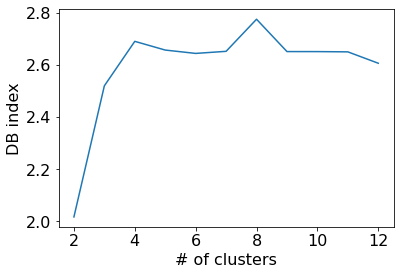

In [37]:
from sklearn.metrics import davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")

result_n = []
for n_clusters in range(2, 13):
    clusterig_result = model_dict['euc_'+str(n_clusters)].predict(CER_rs)
    db_index = davies_bouldin_score(CER_rs, clusterig_result)
    result_n.append(db_index)

plt.figure()
plt.plot(range(2, 13), result_n)
plt.xlabel('# of clusters')
plt.ylabel('DB index')
plt.show()



In [ ]:
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans

# clustering
model_dict_save = dict()
for n_clusters in tqdm(range(2, 20)):
    # 1. KMeans
    model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
        max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
    result = model.fit_predict(SAVE_rs)
    model_dict_save['euc_' + str(n_clusters)] = model


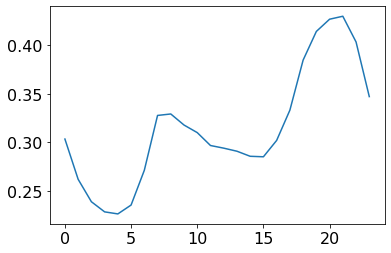

In [89]:
plt.plot(np.mean(ETRI_rs, axis=0))
plt.show()

In [95]:
data =np.var(CER_rs, axis=0)
for i in range(47):
    print(i, data[i+1] - data[i])

0 -0.06224469073198538
1 -0.048206563752524884
2 -0.03224909510147897
3 -0.02359757300735782
4 -0.01466398193530391
5 -0.004224448433885614
6 -0.00461562464507384
7 0.000827615993966524
8 0.008571723325644182
9 0.006840384106524655
10 0.017969975818342532
11 0.03934211954265024
12 0.06486711512196189
13 0.1143305256038041
14 0.09801828916974908
15 0.027063627506005772
16 -0.003749620752386884
17 0.0062641033218728825
18 0.024923428624373578
19 0.03400984392035261
20 0.017794863280091944
21 0.013450239327556957
22 0.02215211363179781
23 0.048174037221618726
24 0.023997632306245964
25 -0.02807038413882723
26 -0.04808334054918917
27 -0.02278058189836618
28 -0.01626576248829381
29 0.0015025996972712896
30 0.027365108441562036
31 0.05073595396445851
32 0.08368483521995207
33 0.1001036792658152
34 0.08176398697212606
35 -0.008270083881902202
36 -0.048863986768692524
37 -0.012349295554973883
38 -0.04580442170064247
39 -0.04992381767985543
40 -0.0483851124055491
41 -0.024862403265824784
42 -0.

In [90]:
from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans

# clustering
model_dict_etri = dict()
for n_clusters in tqdm(range(2, 20)):
    # 1. KMeans
    model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
        max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
    result = model.fit_predict(ETRI_rs)
    model_dict_etri['euc_' + str(n_clusters)] = model

100%|██████████| 18/18 [12:01<00:00, 40.07s/it]



In [106]:
p1 = range(0, 5*2)
p2 = range(5*2, 9*2)
p3 = range(9*2, 12*2)
p4 = range(12*2, 15*2)
p5 = range(15*2, 18*2)
p6 = range(18*2, 21*2)
p7 = range(21*2, 24*2)
time_list = [p1, p2, p3, p4, p5, p6, p7]

model_dict_cer = dict()
for n_clusters in tqdm(range(2, 16)):
    for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(CER_rs[:,part])
        model_dict_cer['euc_part'+str(name)+'_' + str(n_clusters)] = model


--> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 0.420 --> 
1.357 --> 1.082 --> 1.040 --> 1.023 --> 1.016 --> 1.013 --> 1.012 --> 1.011 --> 1.010 --> 1.010 --> 1.010 --> 1.009 --> 1.009 --> 1.008 --> 1.008 --> 1.008 --> 1.007 --> 1.006 --> 1.006 --> 1.005 --> 1.004 --> 1.003 --> 1.003 --> 1.002 --> 1.002 --> 1.002 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 1.001 --> 
1.846 --> 1.454 --> 1.400 --> 1.371 --> 1.356 --> 1.348 --> 1.342 --> 1.337 --> 1.332 --> 1.328 --> 1.325 --> 1.322 --> 1.320 --> 1.318 --> 1.316 --> 1.315 --> 1.314 --> 1.313 --> 1.313 --> 1.312 --> 1.312 --> 1.312 --> 1.312 --> 1.31

KeyboardInterrupt: 

In [ ]:
model_dict_cer.keys()

In [ ]:
p1 = range(0, 5)
p2 = range(5, 9)
p3 = range(9, 12)
p4 = range(12, 15)
p5 = range(15, 18)
p6 = range(18, 21)
p7 = range(21, 24)
time_list = [p1, p2, p3, p4, p5, p6, p7]

for n_clusters in tqdm(range(2, 16)):
    for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
            max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(ETRI_rs[:,part])
        model_dict_etri['euc_part'+str(name)+'_' + str(n_clusters)] = model


In [318]:
# p1 = range(0, 5)
# p2 = range(5, 9)
# p3 = range(9, 12)
# p4 = range(12, 15)
# p5 = range(15, 18)
# p6 = range(18, 21)
# p7 = range(21, 24)
# time_list = [p1, p2, p3, p4, p5, p6, p7]

p1 = list(range(0, 9))
p2 = list(range(9, 18))
p3 = list(range(18, 24))
time_list = [p1, p2, p3]

model_dict_new = dict()

for n_clusters in tqdm(range(2, 10)):
    for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
            max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(ETRI_rs[:,part])
        model_dict_new['ETRI_part'+str(name)+'_' + str(n_clusters)] = model

p1 = list(range(0, 9*2))
p2 = list(range(9*2, 18*2))
p3 = list(range(18*2, 48))
time_list = [p1, p2, p3]

for n_clusters in tqdm(range(2, 10)):
    for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
            max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(SAVE_rs[:,part])
        model_dict_new['SAVE_part'+str(name)+'_' + str(n_clusters)] = model

p1 = list(range(0, 9*2))
p2 = list(range(9*2, 18*2))
p3 = list(range(18*2, 48))
time_list = [p1, p2, p3]

for n_clusters in tqdm(range(2, 10)):
    for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
            max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(CER_rs[:,part])
        model_dict_new['CER_part'+str(name)+'_' + str(n_clusters)] = model



> 0.097 --> 0.097 --> 0.097 --> 0.096 --> 0.096 --> 0.096 --> 0.096 --> 0.096 --> 0.096 --> 0.096 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.095 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 0.094 --> 
0.230 --> 0.193 --> 0.187 --> 0.184 --> 0.182 --> 0.181 --> 0.181 --> 0.180 --> 0.180 --> 0.180 --> 0.180 --> 0.180 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 --> 0.179 -

KeyboardInterrupt: 

In [326]:
for n_clusters in tqdm(range(7, 10)):
    for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
            max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(CER_rs[:,part])
        model_dict_new['CER_part'+str(name)+'_' + str(n_clusters)] = model


  0%|          | 0/3 [00:00<?, ?it/s]4.916 --> 4.016 --> 3.945 --> 3.920 --> 3.904 --> 3.892 --> 3.882 --> 3.873 --> 3.864 --> 3.854 --> 3.844 --> 3.832 --> 3.822 --> 3.813 --> 3.805 --> 3.799 --> 3.796 --> 3.793 --> 3.791 --> 3.790 --> 3.790 --> 3.789 --> 3.789 --> 3.789 --> 3.789 --> 3.789 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 3.788 --> 
0.489 --> 0.369 --> 0.355 --> 0.352 --> 0.351 --> 0.350 --> 0.350 --> 0.350 --> 0.349 --> 0.349 --> 0.349 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.348 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 0.347 --> 
1.234 --> 1.052 --> 1.020 --> 1.004 --> 0.993 --> 0.986 --> 0.983 --> 0.981 --> 0.980 --> 0.979 --> 0

KeyboardInterrupt: 

In [325]:
model_dict_new.keys()

dict_keys(['ETRI_part0_2', 'ETRI_part1_2', 'ETRI_part2_2', 'ETRI_part0_3', 'ETRI_part1_3', 'ETRI_part2_3', 'ETRI_part0_4', 'ETRI_part1_4', 'ETRI_part2_4', 'ETRI_part0_5', 'ETRI_part1_5', 'ETRI_part2_5', 'ETRI_part0_6', 'ETRI_part1_6', 'ETRI_part2_6', 'ETRI_part0_7', 'ETRI_part1_7', 'ETRI_part2_7', 'ETRI_part0_8', 'ETRI_part1_8', 'ETRI_part2_8', 'ETRI_part0_9', 'ETRI_part1_9', 'ETRI_part2_9', 'SAVE_part0_2', 'SAVE_part1_2', 'SAVE_part2_2', 'SAVE_part0_3', 'SAVE_part1_3', 'SAVE_part2_3', 'SAVE_part0_4', 'SAVE_part1_4', 'SAVE_part2_4', 'SAVE_part0_5', 'SAVE_part1_5', 'SAVE_part2_5', 'SAVE_part0_6', 'SAVE_part1_6', 'SAVE_part2_6', 'SAVE_part0_7', 'SAVE_part1_7', 'SAVE_part2_7', 'SAVE_part0_8', 'SAVE_part1_8', 'SAVE_part2_8', 'SAVE_part0_9', 'SAVE_part1_9', 'SAVE_part2_9', 'CER_part0_2', 'CER_part1_2', 'CER_part2_2', 'CER_part0_3', 'CER_part1_3', 'CER_part2_3', 'CER_part0_4', 'CER_part1_4', 'CER_part2_4', 'CER_part0_5', 'CER_part1_5', 'CER_part2_5', 'CER_part0_6', 'CER_part1_6', 'CER_part2_

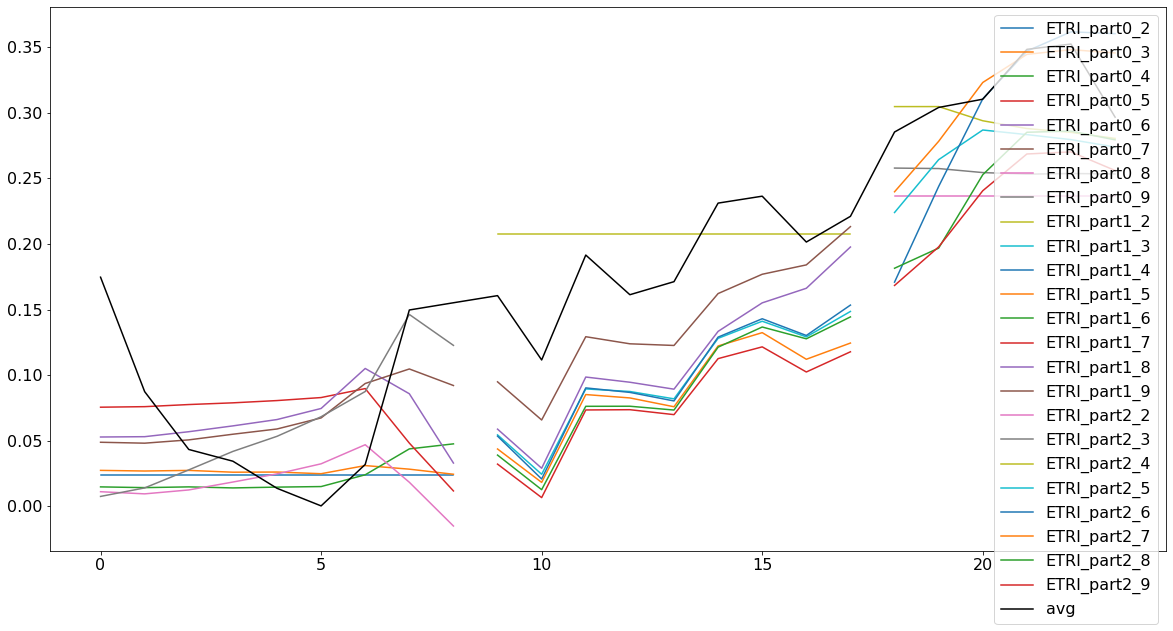

In [324]:
plt.figure(figsize = (20, 10))

data_name = 'ETRI'
# part_name = 'all'

p0 = range(0, 24*2)
p1 = list(range(0, 9*2))
p2 = list(range(9*2, 18*2))
p3 = list(range(18*2, 48))
time_list = [p0, p1, p2, p3, p4, p5, p6, p7]

# data_raw assign
if data_name == 'CER':
    data_raw = CER_rs
    label_raw = CER_label['Q13'].values
    home_arr = home_arr_c
elif data_name == 'SAVE':
    data_raw = SAVE_rs
    label_raw = SAVE_label['Q2'].values
    home_arr = home_arr_s
elif data_name == 'ETRI':
    data_raw = ETRI_rs
    label_raw = ETRI_label['popl_num'].values
    home_arr = home_arr_e
    
    # time frequency가 다름...
    p0 = list(range(0, 24))
    p1 = list(range(0, 9))
    p2 = list(range(9, 18))
    p3 = list(range(18, 24))
    time_list = [p0, p1, p2, p3, p4, p5, p6, p7]

invalid_idx = pd.isnull(label_raw)
# label_raw = label_raw[~invalid_idx]
invalid_home_num = np.where(invalid_idx)[0]
valid_home_idx = np.zeros(home_arr.shape, dtype = bool)
for j in range(home_arr.shape[0]):
    if home_arr[j] in invalid_home_num:
        valid_home_idx[j] = False
    else:
        valid_home_idx[j] = True
data_raw = data_raw[valid_home_idx,:]
home_arr = home_arr[valid_home_idx]
unique_home_arr = np.unique(home_arr)
label = np.array([label_raw[u] for u in unique_home_arr])

for i, part_name in enumerate(['all','part0', 'part1','part2']):    
    data = data_raw[:,time_list[i]]
 
    # for each cluster
    for N_Cluster in range(2, 12):
        key = f'{data_name}_{part_name}_{N_Cluster}'
        if key in model_dict_new.keys():
            # load model
            model = model_dict_new[key]
            
            # 대표부하 extract
            rep_load_for_each_cluster = []
            for n_c in range(N_Cluster):
                clusterig_result = model.predict(data)
                idx2 = clusterig_result == n_c
                rep_load_for_each_cluster.append(data[idx2,:].mean(axis=0))
            rep_cluster, rep_load_list, label_list = [], [], []
            for h in unique_home_arr:
                idx1 = home_arr == h
                v, c= np.unique(clusterig_result[idx1], return_counts=True)
                rep_c = v[np.argmax(c)]
                rep_cluster.append(rep_c)
                label_list.append(label_raw[h])
                rep_load_list.append(rep_load_for_each_cluster[rep_c])

            rep_load_arr = np.array(rep_load_list)
            
            # correlation 구하기
            corr_list = []
            for j in range(rep_load_arr.shape[1]):
                corr_list.append(np.corrcoef(rep_load_arr[:,j], np.ravel(label))[0,1])
            corr_list = np.array(corr_list)

            plt.plot(time_list[i], corr_list, label = key)

### reference - average
rep_cluster, rep_load_list, label_list = [], [], []
for h in unique_home_arr:
    idx1 = home_arr == h
    rep_load_list.append(np.mean(data_raw[idx1,:], axis=0))
    label_list.append(label_raw[h])
rep_load_arr = np.array(rep_load_list)
# correlation 구하기
corr_list = []
for j in range(rep_load_arr.shape[1]):
    corr_list.append(np.corrcoef(rep_load_arr[:,j], np.ravel(label))[0,1])
corr_list = np.array(corr_list)
plt.plot(time_list[0], corr_list, label = 'avg', color = 'k')

plt.legend()
plt.show()


In [317]:
model_dict_cer.keys()

dict_keys(['euc_part0_2', 'euc_part1_2', 'euc_part2_2', 'euc_part3_2', 'euc_part4_2', 'euc_part5_2', 'euc_part6_2', 'euc_part0_3', 'euc_part1_3', 'euc_part2_3', 'euc_part3_3', 'euc_part4_3', 'euc_part5_3', 'euc_part6_3', 'euc_part0_4', 'euc_part1_4', 'euc_part2_4', 'euc_part3_4', 'euc_part4_4', 'euc_part5_4', 'euc_part6_4', 'euc_part0_5', 'euc_part1_5', 'euc_part2_5', 'euc_part3_5', 'euc_part4_5', 'euc_part5_5', 'euc_part6_5', 'euc_part0_6', 'euc_part1_6', 'euc_part2_6', 'euc_part3_6', 'euc_part4_6', 'euc_part5_6', 'euc_part6_6', 'euc_part0_7', 'euc_part1_7', 'euc_part2_7', 'euc_part3_7', 'euc_part4_7', 'euc_part5_7', 'euc_part6_7', 'euc_part0_8', 'euc_part1_8', 'euc_part2_8', 'euc_part3_8', 'euc_part4_8', 'euc_part5_8', 'euc_part6_8', 'euc_part0_9', 'euc_part1_9', 'euc_part2_9', 'euc_part3_9', 'euc_part4_9'])

In [ ]:
p1 = range(0, 5*2)
p2 = range(5*2, 9*2)
p3 = range(9*2, 12*2)
p4 = range(12*2, 15*2)
p5 = range(15*2, 18*2)
p6 = range(18*2, 21*2)
p7 = range(21*2, 24*2)
time_list = [p1, p2, p3, p4, p5, p6, p7]

# model_dict_cer = dict()
for n_clusters in tqdm(range(2, 16)):
        for name, part in enumerate(time_list):
        # 1. KMeans
        model = TimeSeriesKMeans(n_clusters = n_clusters, metric = 'euclidean', \
            max_iter = 10000000, random_state = 0, verbose = 1, n_jobs=-1)
        result = model.fit_predict(SAVE_rs[:,part])
        model_dict_save['euc_2_part'+str(name)+'_' + str(n_clusters)] = model


In [111]:
### model save
import pickle

with open('clustering_result/CER_model_dict_0530.pickle', 'wb') as handle:
    pickle.dump(model_dict_cer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clustering_result/ETRI_model_dict_0530.pickle', 'wb') as handle:
    pickle.dump(model_dict_etri, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('clustering_result/SAVE_model_dict_0530.pickle', 'wb') as handle:
    pickle.dump(model_dict_save, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [114]:
model_dict.keys()

dict_keys(['euc_p1_2', 'euc_p2_2', 'euc_p1_3', 'euc_p2_3', 'euc_p1_4', 'euc_p2_4', 'euc_p1_5', 'euc_p2_5', 'euc_p1_6', 'euc_p2_6', 'euc_p1_7', 'euc_p2_7', 'euc_p1_8', 'euc_p2_8', 'euc_p1_9', 'euc_p2_9', 'euc_p1_10', 'euc_p2_10', 'euc_p1_11', 'euc_p2_11', 'euc_p1_12', 'euc_p2_12', 'euc_p1_13', 'euc_p2_13', 'euc_p1_14', 'euc_p2_14', 'euc_p1_15', 'euc_p2_15', 'euc_p1_16', 'euc_p2_16', 'euc_p1_17', 'euc_p2_17', 'euc_p1_18', 'euc_p2_18', 'euc_p1_19', 'euc_p2_19', 'euc_2', 'euc_3', 'euc_4', 'euc_5', 'euc_6', 'euc_7', 'euc_8', 'euc_9', 'euc_10', 'euc_11', 'euc_12', 'euc_13'])

In [115]:
# DB index
from sklearn.metrics import davies_bouldin_score
import warnings
warnings.filterwarnings("ignore")

result_n = []
for n_clusters in range(2, 13):
    clusterig_result = model_dict['euc_'+str(n_clusters)].predict(CER_rs)
    db_index = davies_bouldin_score(CER_rs, clusterig_result)
    result_n.append(db_index)

plt.figure()
plt.plot(range(2, 13), result_n)
plt.xlabel('# of clusters')
plt.ylabel('DB index')
plt.show()


In [117]:
model_dict_cer.keys()

dict_keys(['euc_part0_2', 'euc_part1_2', 'euc_part2_2', 'euc_part3_2', 'euc_part4_2', 'euc_part5_2', 'euc_part6_2', 'euc_part0_3', 'euc_part1_3', 'euc_part2_3', 'euc_part3_3', 'euc_part4_3', 'euc_part5_3', 'euc_part6_3', 'euc_part0_4', 'euc_part1_4', 'euc_part2_4', 'euc_part3_4', 'euc_part4_4', 'euc_part5_4', 'euc_part6_4', 'euc_part0_5', 'euc_part1_5', 'euc_part2_5', 'euc_part3_5', 'euc_part4_5', 'euc_part5_5', 'euc_part6_5', 'euc_part0_6', 'euc_part1_6', 'euc_part2_6', 'euc_part3_6', 'euc_part4_6', 'euc_part5_6', 'euc_part6_6', 'euc_part0_7', 'euc_part1_7', 'euc_part2_7', 'euc_part3_7', 'euc_part4_7', 'euc_part5_7', 'euc_part6_7', 'euc_part0_8', 'euc_part1_8', 'euc_part2_8', 'euc_part3_8', 'euc_part4_8', 'euc_part5_8', 'euc_part6_8', 'euc_part0_9', 'euc_part1_9', 'euc_part2_9', 'euc_part3_9', 'euc_part4_9'])

### Clustering 결과 분석

In [122]:
label_raw = CER_label['Q13'].values
rep_load_dict = dict()
label_dict = dict()

unique_home_arr = np.unique(home_arr)

rep_cluster, rep_load_list, label_list = [], [], []
for h in unique_home_arr:
    idx1 = home_arr == h
    data = np.mean(CER_rs[idx1,:], axis=0)
    rep_load_list.append(data)
    label_list.append(label_raw[h])

rep_load_arr = np.array(rep_load_list)
# rep_load_arr_ex = feature_extraction(rep_load_arr).T
# rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)

rep_load_dict['6 month avg'] = rep_load_arr
label_dict['6 month avg'] = np.array(label_list)

In [134]:
p1 = range(0, 5*2)
p2 = range(5*2, 9*2)
p3 = range(9*2, 12*2)
p4 = range(12*2, 15*2)
p5 = range(15*2, 18*2)
p6 = range(18*2, 21*2)
p7 = range(21*2, 24*2)
time_list = [p1, p2, p3, p4, p5, p6, p7]

unique_home_arr = np.unique(home_arr)

for i in range(0, 7):
    data = CER_rs[:,time_list[i]]
    for N_Cluster in range(2, 9):
        rep_load_for_each_cluster = []
        for n_c in range(N_Cluster):
            key = f'euc_part{i}_{N_Cluster}'
            clusterig_result = model_dict_cer[key].labels_
            idx2 = clusterig_result == n_c
            rep_load_for_each_cluster.append(data[idx2,:].mean(axis=0))

        rep_cluster, rep_load_list, label_list = [], [], []
        for h in unique_home_arr:
            idx1 = home_arr == h
            v, c= np.unique(clusterig_result[idx1], return_counts=True)
            rep_c = v[np.argmax(c)]
            rep_cluster.append(rep_c)
            label_list.append(label_raw[h])
            rep_load_list.append(rep_load_for_each_cluster[rep_c])

        rep_load_arr = np.array(rep_load_list)
        # rep_load_arr_ex = feature_extraction(rep_load_arr).T
        # rep_load_arr = np.concatenate([rep_load_arr, rep_load_arr_ex], axis=1)

        rep_load_dict[f'kmeans-part{i}_{N_Cluster}'] = rep_load_arr
        label_dict[f'kmeans-part{i}_{N_Cluster}'] = np.array(label_list)



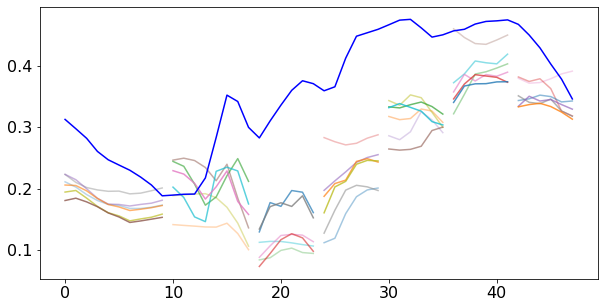

In [136]:
p1 = range(0, 5*2)
p2 = range(5*2, 9*2)
p3 = range(9*2, 12*2)
p4 = range(12*2, 15*2)
p5 = range(15*2, 18*2)
p6 = range(18*2, 21*2)
p7 = range(21*2, 24*2)
time_list = [p1, p2, p3, p4, p5, p6, p7]

plt.figure(figsize = (10, 5))

for N_Cluster in range(3, 9):
    for i in range(7):
        key = f'kmeans-part{i}_{N_Cluster}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(time_list[i], np.abs(corr_list),label = key, alpha = N_Cluster * 0.1)

key = '6 month avg'
data = rep_load_dict[key]
label = label_dict[key]
corr_list = []
for j in range(data.shape[1]):
    corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])

plt.plot(np.abs(corr_list)[:48], label = key, color = 'b')

# plt.legend()
plt.show()

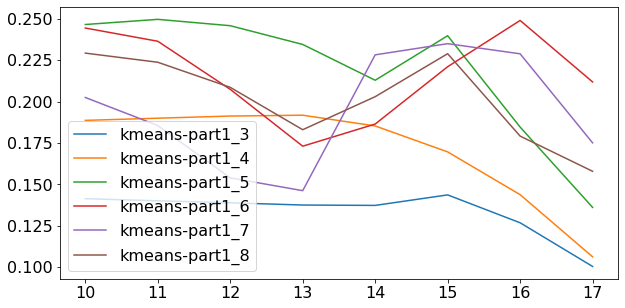

In [148]:
p1 = range(0, 5*2)
p2 = range(5*2, 9*2)
p3 = range(9*2, 12*2)
p4 = range(12*2, 15*2)
p5 = range(15*2, 18*2)
p6 = range(18*2, 21*2)
p7 = range(21*2, 24*2)
time_list = [p1, p2, p3, p4, p5, p6, p7]

plt.figure(figsize = (10, 5))

for N_Cluster in range(3, 9):
    for i in [1]:
        key = f'kmeans-part{i}_{N_Cluster}'

        data = rep_load_dict[key]
        label = label_dict[key]

        corr_list = []
        for j in range(data.shape[1]):
            corr_list.append(np.corrcoef(data[:,j], np.ravel(label))[0,1])
        corr_list = np.array(corr_list)
        plt.plot(time_list[i], np.abs(corr_list),label = key)

plt.legend()
plt.show()

In [152]:
# 현재 모델: model_dict, model_dict_cer, model_dict_save, model_dict_etri
print('===기존===')
print(model_dict.keys())
print('===CER===')
print(model_dict_cer.keys())
print('===SAVE===')
print(model_dict_save.keys())
print('===ETRI===')
print(model_dict_etri.keys())


===기존===
dict_keys(['euc_p1_2', 'euc_p2_2', 'euc_p1_3', 'euc_p2_3', 'euc_p1_4', 'euc_p2_4', 'euc_p1_5', 'euc_p2_5', 'euc_p1_6', 'euc_p2_6', 'euc_p1_7', 'euc_p2_7', 'euc_p1_8', 'euc_p2_8', 'euc_p1_9', 'euc_p2_9', 'euc_p1_10', 'euc_p2_10', 'euc_p1_11', 'euc_p2_11', 'euc_p1_12', 'euc_p2_12', 'euc_p1_13', 'euc_p2_13', 'euc_p1_14', 'euc_p2_14', 'euc_p1_15', 'euc_p2_15', 'euc_p1_16', 'euc_p2_16', 'euc_p1_17', 'euc_p2_17', 'euc_p1_18', 'euc_p2_18', 'euc_p1_19', 'euc_p2_19', 'euc_2', 'euc_3', 'euc_4', 'euc_5', 'euc_6', 'euc_7', 'euc_8', 'euc_9', 'euc_10', 'euc_11', 'euc_12', 'euc_13'])
===CER===
dict_keys(['euc_part0_2', 'euc_part1_2', 'euc_part2_2', 'euc_part3_2', 'euc_part4_2', 'euc_part5_2', 'euc_part6_2', 'euc_part0_3', 'euc_part1_3', 'euc_part2_3', 'euc_part3_3', 'euc_part4_3', 'euc_part5_3', 'euc_part6_3', 'euc_part0_4', 'euc_part1_4', 'euc_part2_4', 'euc_part3_4', 'euc_part4_4', 'euc_part5_4', 'euc_part6_4', 'euc_part0_5', 'euc_part1_5', 'euc_part2_5', 'euc_part3_5', 'euc_part4_5', 'euc

In [161]:
kmeans_merge = dict()

for n in range(2, 20):
    for i in range(7):
        key = f'euc_part{i}_{n}'
        if key in model_dict_cer.keys():
            kmeans_merge[f'CER_T{i}_{n}'] = model_dict_cer[key]
    key = f'euc_{n}'
    if key in model_dict.keys():
        kmeans_merge[f'CER_all_{n}'] = model_dict[key]

for n in range(2, 20):
    for i in range(7):
        key = f'euc_part{i}_{n}'
        if key in model_dict_save.keys():
            kmeans_merge[f'SAVE_T{i}_{n}'] = model_dict_save[key]
    key = f'euc_{n}'
    if key in model_dict_save.keys():
        kmeans_merge[f'SAVE_all_{n}'] = model_dict_save[key]

for n in range(2, 20):
    for i in range(7):
        key = f'euc_part{i}_{n}'
        if key in model_dict_etri.keys():
            kmeans_merge[f'ETRI_T{i}_{n}'] = model_dict_etri[key]
    key = f'euc_{n}'
    if key in model_dict_etri.keys():
        kmeans_merge[f'ETRI_all_{n}'] = model_dict_etri[key]



In [163]:
kmeans_merge.keys()

dict_keys(['CER_T0_2', 'CER_T1_2', 'CER_T2_2', 'CER_T3_2', 'CER_T4_2', 'CER_T5_2', 'CER_T6_2', 'CER_all_2', 'CER_T0_3', 'CER_T1_3', 'CER_T2_3', 'CER_T3_3', 'CER_T4_3', 'CER_T5_3', 'CER_T6_3', 'CER_all_3', 'CER_T0_4', 'CER_T1_4', 'CER_T2_4', 'CER_T3_4', 'CER_T4_4', 'CER_T5_4', 'CER_T6_4', 'CER_all_4', 'CER_T0_5', 'CER_T1_5', 'CER_T2_5', 'CER_T3_5', 'CER_T4_5', 'CER_T5_5', 'CER_T6_5', 'CER_all_5', 'CER_T0_6', 'CER_T1_6', 'CER_T2_6', 'CER_T3_6', 'CER_T4_6', 'CER_T5_6', 'CER_T6_6', 'CER_all_6', 'CER_T0_7', 'CER_T1_7', 'CER_T2_7', 'CER_T3_7', 'CER_T4_7', 'CER_T5_7', 'CER_T6_7', 'CER_all_7', 'CER_T0_8', 'CER_T1_8', 'CER_T2_8', 'CER_T3_8', 'CER_T4_8', 'CER_T5_8', 'CER_T6_8', 'CER_all_8', 'CER_T0_9', 'CER_T1_9', 'CER_T2_9', 'CER_T3_9', 'CER_T4_9', 'CER_all_9', 'CER_all_10', 'CER_all_11', 'CER_all_12', 'CER_all_13', 'SAVE_all_2', 'SAVE_all_3', 'SAVE_all_4', 'SAVE_all_5', 'SAVE_all_6', 'SAVE_all_7', 'SAVE_all_8', 'SAVE_all_9', 'SAVE_all_10', 'SAVE_all_11', 'SAVE_all_12', 'SAVE_all_13', 'SAVE_all

In [ ]:
import pickle

with open('clustering_result/kmeans_0530.pickle', 'wb') as handle:
    pickle.dump(kmeans_merge, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 결과 확인

In [ ]:
for data, data_label in zip([CER_rs, SAVE_rs, ETRI_rs], [CER_label['']]):
    

### 시각화부터 하자

In [165]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
CER_pca = pca.fit_transform(CER_rs)


In [167]:
pca.explained_variance_ratio_

array([0.28955192, 0.08362048])

In [174]:
class_ = []
for i in range(home_arr.shape[0]):
    class_.append(CER_label['Q13'].iloc[home_arr[i]])

In [178]:
np.unique(class_)

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 12])

In [ ]:
class_ = np.array(class_)
for i in range(1, 6):
    plt.figure(figsize = (10, 10))
    idx = class_ == i
    plt.plot(CER_pca[idx, 0], CER_pca[idx, 1],'.', label = i)
    plt.legend()
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.show()

In [ ]:
CER_pca = pca.fit_transform(CER_rs)

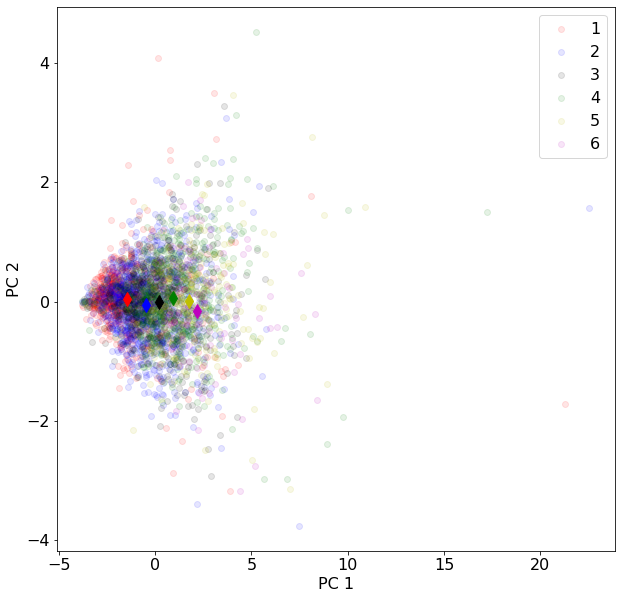

In [235]:
load_pca = pca.fit_transform(rep_load_dict['6 month avg'])
plt.figure(figsize = (10, 10))

colors = ['r','b','k','g','y','m']

for i in range(1, 7):
    idx = label_dict['6 month avg'] == i
    plt.scatter(load_pca[idx, 0], load_pca[idx, 1], label = i, alpha =0.1, color = colors[i-1])
    plt.plot(load_pca[idx, :].mean(axis=0)[0], load_pca[idx, :].mean(axis=0)[1],'d', markersize = 10, color = colors[i-1])
    plt.legend()
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
plt.show()

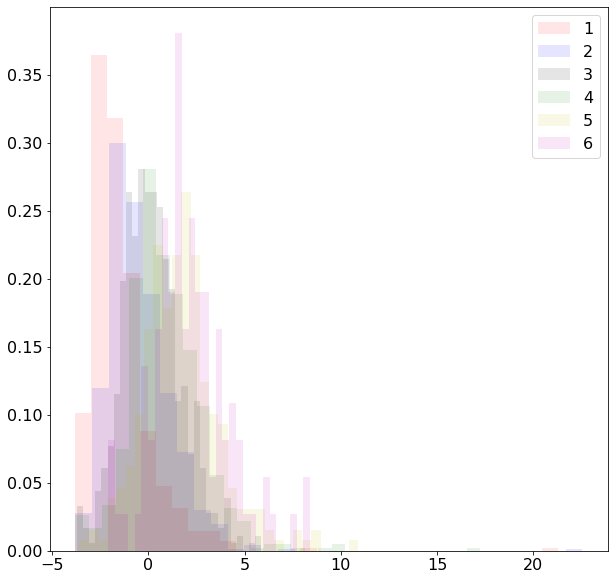

In [239]:
load_pca = pca.fit_transform(rep_load_dict['6 month avg'])
plt.figure(figsize = (10, 10))

colors = ['r','b','k','g','y','m']

for i in range(1, 7):
    idx = label_dict['6 month avg'] == i
    plt.hist(load_pca[idx, 0].reshape(-1), label = i, alpha =0.1, color = colors[i-1], bins = 30, density = True)
plt.legend()
# plt.xlabel('PC 1')
# plt.ylabel('PC 2')
plt.show()

# Clustering 결과 시각화

In [240]:
kmeans_merge.keys()

dict_keys(['CER_T0_2', 'CER_T1_2', 'CER_T2_2', 'CER_T3_2', 'CER_T4_2', 'CER_T5_2', 'CER_T6_2', 'CER_all_2', 'CER_T0_3', 'CER_T1_3', 'CER_T2_3', 'CER_T3_3', 'CER_T4_3', 'CER_T5_3', 'CER_T6_3', 'CER_all_3', 'CER_T0_4', 'CER_T1_4', 'CER_T2_4', 'CER_T3_4', 'CER_T4_4', 'CER_T5_4', 'CER_T6_4', 'CER_all_4', 'CER_T0_5', 'CER_T1_5', 'CER_T2_5', 'CER_T3_5', 'CER_T4_5', 'CER_T5_5', 'CER_T6_5', 'CER_all_5', 'CER_T0_6', 'CER_T1_6', 'CER_T2_6', 'CER_T3_6', 'CER_T4_6', 'CER_T5_6', 'CER_T6_6', 'CER_all_6', 'CER_T0_7', 'CER_T1_7', 'CER_T2_7', 'CER_T3_7', 'CER_T4_7', 'CER_T5_7', 'CER_T6_7', 'CER_all_7', 'CER_T0_8', 'CER_T1_8', 'CER_T2_8', 'CER_T3_8', 'CER_T4_8', 'CER_T5_8', 'CER_T6_8', 'CER_all_8', 'CER_T0_9', 'CER_T1_9', 'CER_T2_9', 'CER_T3_9', 'CER_T4_9', 'CER_all_9', 'CER_all_10', 'CER_all_11', 'CER_all_12', 'CER_all_13', 'SAVE_all_2', 'SAVE_all_3', 'SAVE_all_4', 'SAVE_all_5', 'SAVE_all_6', 'SAVE_all_7', 'SAVE_all_8', 'SAVE_all_9', 'SAVE_all_10', 'SAVE_all_11', 'SAVE_all_12', 'SAVE_all_13', 'SAVE_all

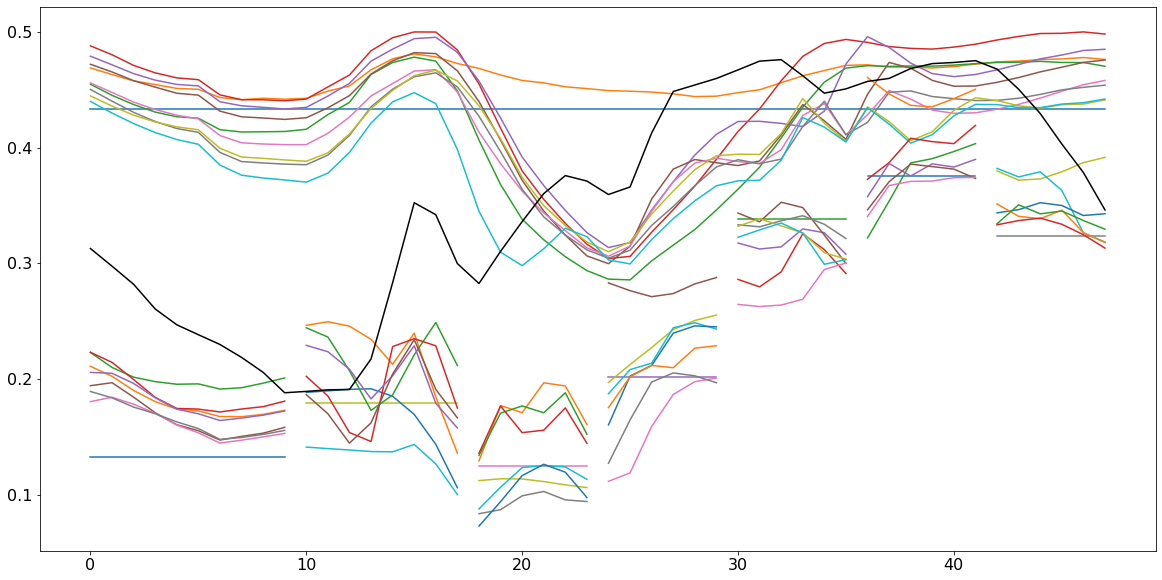

In [316]:
plt.figure(figsize = (20, 10))

data_name = 'CER'
# part_name = 'all'

p0 = range(0, 24*2)
p1 = range(0, 5*2)
p2 = range(5*2, 9*2)
p3 = range(9*2, 12*2)
p4 = range(12*2, 15*2)
p5 = range(15*2, 18*2)
p6 = range(18*2, 21*2)
p7 = range(21*2, 24*2)
time_list = [p0, p1, p2, p3, p4, p5, p6, p7]

# data_raw assign
if data_name == 'CER':
    data_raw = CER_rs
    label_raw = CER_label['Q13'].values
    home_arr = home_arr_c
elif data_name == 'SAVE':
    data_raw = SAVE_rs
    label_raw = SAVE_label['Q2'].values
    home_arr = home_arr_s
elif data_name == 'ETRI':
    data_raw = ETRI_rs
    label_raw = ETRI_label['popl_num'].values
    home_arr = home_arr_e
    
    # time frequency가 다름...
    p0 = range(0, 24)
    p1 = range(0, 5)
    p2 = range(5, 9)
    p3 = range(9, 12)
    p4 = range(12, 15)
    p5 = range(15, 18)
    p6 = range(18, 21)
    p7 = range(21, 24)
    time_list = [p0, p1, p2, p3, p4, p5, p6, p7]

invalid_idx = pd.isnull(label_raw)
# label_raw = label_raw[~invalid_idx]
invalid_home_num = np.where(invalid_idx)[0]
valid_home_idx = np.zeros(home_arr.shape, dtype = bool)
for j in range(home_arr.shape[0]):
    if home_arr[j] in invalid_home_num:
        valid_home_idx[j] = False
    else:
        valid_home_idx[j] = True
data_raw = data_raw[valid_home_idx,:]
home_arr = home_arr[valid_home_idx]
unique_home_arr = np.unique(home_arr)
label = np.array([label_raw[u] for u in unique_home_arr])

for i, part_name in enumerate(['all','T0','T1','T2','T3','T4','T5','T6']):    
    data = data_raw[:,time_list[i]]
 
    # for each cluster
    for N_Cluster in range(2, 12):
        key = f'{data_name}_{part_name}_{N_Cluster}'
        if key in kmeans_merge.keys():
            # load model
            model = kmeans_merge[key]
            
            # 대표부하 extract
            rep_load_for_each_cluster = []
            for n_c in range(N_Cluster):
                clusterig_result = model.predict(data)
                idx2 = clusterig_result == n_c
                rep_load_for_each_cluster.append(data[idx2,:].mean(axis=0))
            rep_cluster, rep_load_list, label_list = [], [], []
            for h in unique_home_arr:
                idx1 = home_arr == h
                v, c= np.unique(clusterig_result[idx1], return_counts=True)
                rep_c = v[np.argmax(c)]
                rep_cluster.append(rep_c)
                label_list.append(label_raw[h])
                rep_load_list.append(rep_load_for_each_cluster[rep_c])

            rep_load_arr = np.array(rep_load_list)
            
            # correlation 구하기
            corr_list = []
            for j in range(rep_load_arr.shape[1]):
                corr_list.append(np.corrcoef(rep_load_arr[:,j], np.ravel(label))[0,1])
            corr_list = np.array(corr_list)

            plt.plot(time_list[i], corr_list, label = key)

### reference - average
rep_cluster, rep_load_list, label_list = [], [], []
for h in unique_home_arr:
    idx1 = home_arr == h
    rep_load_list.append(np.mean(data_raw[idx1,:], axis=0))
    label_list.append(label_raw[h])
rep_load_arr = np.array(rep_load_list)
# correlation 구하기
corr_list = []
for j in range(rep_load_arr.shape[1]):
    corr_list.append(np.corrcoef(rep_load_arr[:,j], np.ravel(label))[0,1])
corr_list = np.array(corr_list)
plt.plot(time_list[0], corr_list, label = 'avg', color = 'k')

# plt.legend()
plt.show()


In [327]:
# model save
import pickle

with open('clustering_result/kmeans_partitioning_0531.pickle', 'wb') as handle:
    pickle.dump(model_dict_new, handle, protocol=pickle.HIGHEST_PROTOCOL)